# Apply Case Study: Squares

Author: Ben Tarrahi

A 3-class image classification problem with given train and validation splits
- Images (RGB) have different formats and sizes
- There are 1500 train images (500 each class) and 1500 validation images (500 each class)
- Building an image classifier and validating on the validation set

Steps:
- Visual analysis of the given images and their visual features: e.g. detecting colors, texture, and shape features
- Visual feature detection and extraction
- Creating clean dataset (train and validation) for model building (feature matrix and label vector) 
- Feature analysis
- Training different models and validation
- Obtaining feature importance

In [2]:
import glob
import skimage
from skimage import io
from skimage import exposure
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [3]:
classes = ['a','b','c']

## Visual Analysis

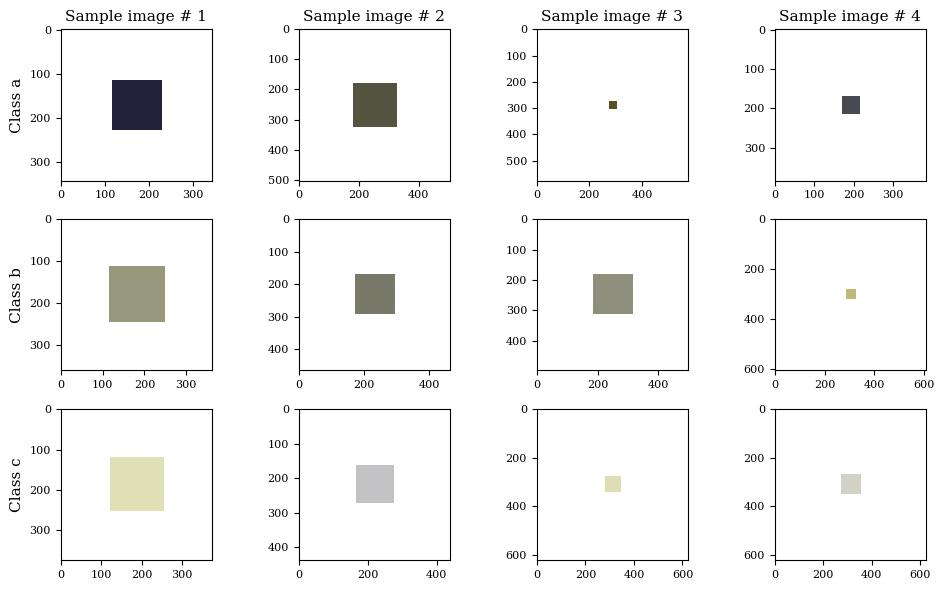

In [49]:
# load some images from each class and show
plt.figure(figsize=(10, 6), dpi=100)
plt.rc('font', family='serif')
myfontsize = 11
ind = 0
for ind_cls, clss in enumerate(classes):
    img_lst = glob.glob("squares/train/"+clss+"/*")
    for img_path in img_lst[:4]:
        img = io.imread(img_path)
        ax = plt.subplot(3,4,ind+1)
        plt.imshow(img)
        if ind%4==0:
            plt.ylabel("Class "+clss,fontsize=myfontsize)
        
        if ind<4:
            plt.title("Sample image # "+str(ind+1),fontsize=myfontsize)
            
        plt.tick_params(axis='both', which='major', labelsize=8)
        ind+=1

plt.tight_layout()

## Feature Extraction

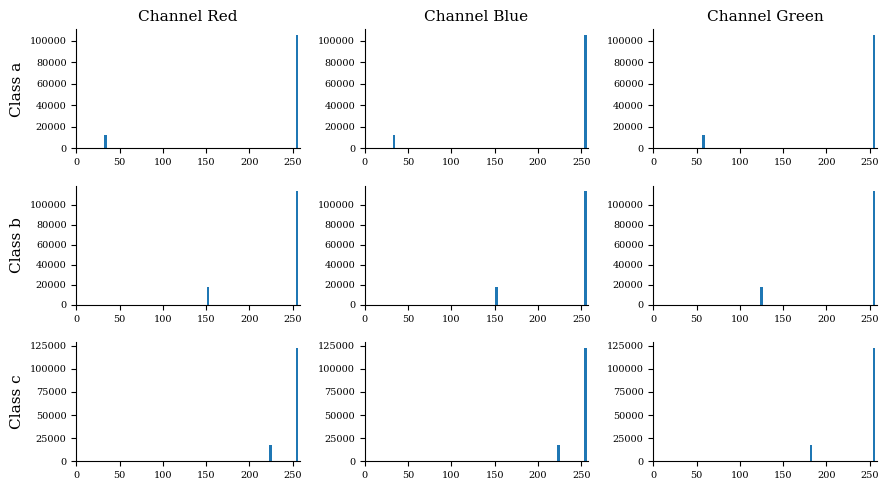

In [5]:
# plot image histogram for each channel, a sample from each class
# default color of each channel = white = 255
# each channel of square has only one color (other than 255) most of the time
channels = ['Red','Blue','Green']
plt.figure(figsize=(9, 5), dpi=100)
plt.rc('font', family='serif')
myfontsize = 11
ind = 0
for ind_cls, clss in enumerate(classes):
    img_lst = glob.glob("squares/train/"+clss+"/*")
    img_path = img_lst[0] # first image of each class
    img = io.imread(img_path)
    for ic,ch in enumerate(channels): # number of channels
        freq, bins = exposure.histogram(img[:,:,ic])
        ax = plt.subplot(3,3,ind+1)
        plt.bar(bins, freq, width=3)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        plt.xlim([0,258])
        if ind%3==0:
            plt.ylabel("Class "+clss,fontsize=myfontsize)
        
        if ind<3:
            plt.title("Channel "+ch,fontsize=myfontsize)
            
        plt.tick_params(axis='both', which='major', labelsize=7)
        ind+=1

plt.tight_layout()

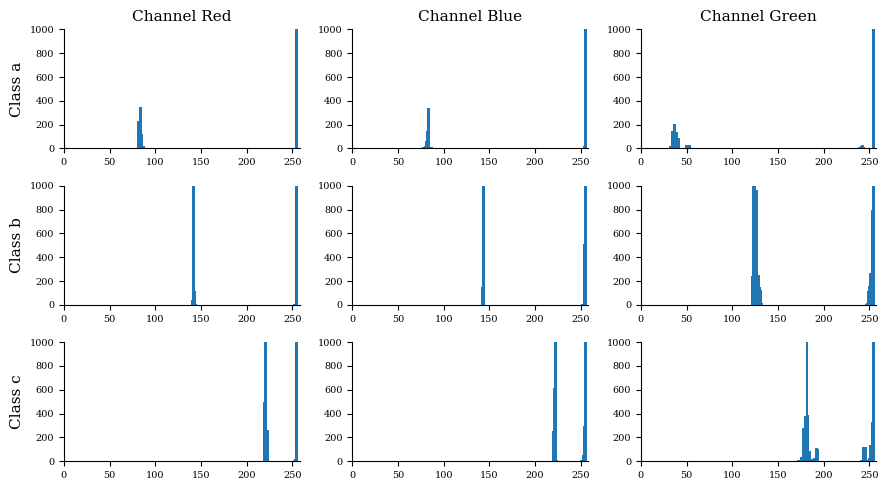

In [6]:
# plot image histogram for each channel, a sample from each class
# default color of each channel = white = 255
# sample image with more than one color per channel
# y axis zoomed in
channels = ['Red','Blue','Green']
plt.figure(figsize=(9, 5), dpi=100)
plt.rc('font', family='serif')
myfontsize = 11
ind = 0
for ind_cls, clss in enumerate(classes):
    img_lst = glob.glob("squares/train/"+clss+"/*")
    i_img = 0
    img_path = img_lst[i_img]
    img = io.imread(img_path)
    while np.unique(img[:,:,0]).shape[0]==2: # find an image with more than one color in the square
        i_img += 1
        img_path = img_lst[i_img]
        img = io.imread(img_path)
    
    for ic,ch in enumerate(channels): # number of channels
        freq, bins =exposure.histogram(img[:,:,ic])
        ax = plt.subplot(3,3,ind+1)
        plt.bar(bins, freq, width=3)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        plt.xlim([0,258])
        plt.ylim([0,1000])
        if ind%3==0:
            plt.ylabel("Class "+clss,fontsize=myfontsize)
        
        if ind<3:
            plt.title("Channel "+ch,fontsize=myfontsize)
            
        plt.tick_params(axis='both', which='major', labelsize=7)
        ind+=1

plt.tight_layout()
# zoomed in y axis

## Data Preparation

In [51]:
# create train data
# read images of each class and extract relevant features
# extract major color of each channel: there may be more than one color in the square in each channel
# extract location and size of the sqaure in the image

labels = []
feat_mat = []
for ind_cls, clss in enumerate(classes):
    img_lst = glob.glob("squares/train/"+clss+"/*")
    for img_path in img_lst:
        img = io.imread(img_path)
        mjr_col_ch = []
        for ic in range(3): # get major color of each channel
            # get image color histogram of each channel
            freq, bins = exposure.histogram(img[:,:,ic])
            ind_srt = freq.argsort()[::-1]
            mjr_col_ch.append(bins[ind_srt[1]]) # pick the 2nd most frequent color (most frequent is 255)
        
        # get the location and size (normalized to image size) of the colored square shape
        sq_inds = np.where(img[:,:,0]<255)
        loc = min(sq_inds[0])/img.shape[0] # top left location (normalized)
        size = (max(sq_inds[0])-min(sq_inds[0]))/img.shape[0]

        feat_mat.append(mjr_col_ch+[loc,size])
        labels.append(ind_cls)

tr_feat_mat = np.array(feat_mat)
tr_labels = np.array(labels)
# shuffle train data
shfl_inds = np.random.permutation(len(tr_labels))
tr_feat_mat = tr_feat_mat[shfl_inds,:]
tr_labels = tr_labels[shfl_inds]
print('Train feature matrix shape:',tr_feat_mat.shape,', label shape:', tr_labels.shape)

Train feature matrix shape: (1500, 5) , label shape: (1500,)


In [52]:
# create validation data

labels = []
feat_mat = []
val_img_paths = []
for ind_cls, clss in enumerate(classes):
    img_lst = glob.glob("squares/val/"+clss+"/*")
    for img_path in img_lst:
        val_img_paths.append(img_path)
        img = io.imread(img_path)
        mjr_col_ch = []
        for ic in range(3): # get major color of each channel
            # get image color histogram of each channel
            freq, bins = exposure.histogram(img[:,:,ic])
            ind_srt = freq.argsort()[::-1]
            mjr_col_ch.append(bins[ind_srt[1]]) # pick the 2nd most frequent color
        
        # get the location and size (normalized to image size) of the colored square shape
        sq_inds = np.where(img[:,:,0]<255)
        loc = min(sq_inds[0])/img.shape[0] # top left location (normalized)
        size = (max(sq_inds[0])-min(sq_inds[0]))/img.shape[0]

        feat_mat.append(mjr_col_ch+[loc,size])
        labels.append(ind_cls)

val_feat_mat = np.array(feat_mat)
val_labels = np.array(labels)
print('Validation feature matrix shape:',tr_feat_mat.shape,', label shape:', tr_labels.shape)

Validation feature matrix shape: (1500, 5) , label shape: (1500,)


## Feature Analysis

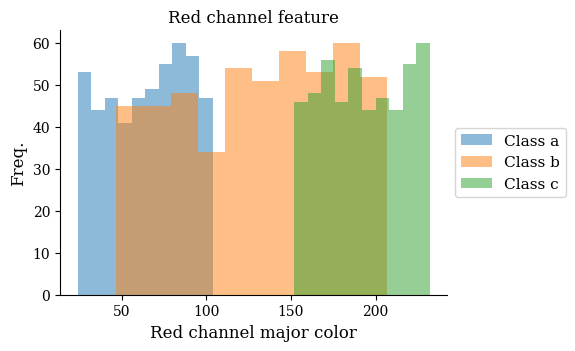

In [53]:
# first (red) channel feature comparison among classes
plt.figure(figsize=(5, 3.5), dpi=100)
plt.rc('font', family='serif')
myfontsize = 12
ax = plt.subplot()
feat_ind = 0
plt.hist(tr_feat_mat[np.where(tr_labels==0)[0],feat_ind],alpha=0.5,label='Class a')
plt.hist(tr_feat_mat[np.where(tr_labels==1)[0],feat_ind],alpha=0.5,label='Class b')
plt.hist(tr_feat_mat[np.where(tr_labels==2)[0],feat_ind],alpha=0.5,label='Class c')
plt.title('Red channel feature',fontsize=myfontsize)
plt.xlabel("Red channel major color",fontsize=myfontsize)
plt.ylabel("Freq.",fontsize=myfontsize)
plt.tick_params(axis='both', which='major', labelsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=11)
print()

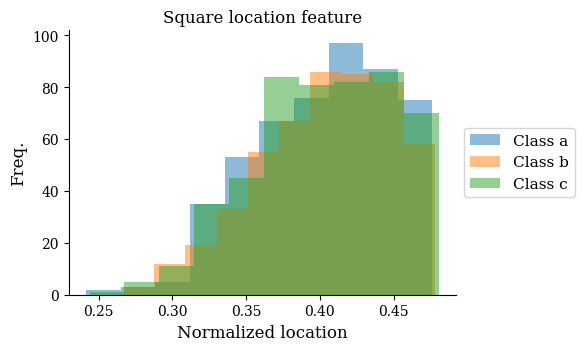

In [54]:
# square loc feature comparison among classes
plt.figure(figsize=(5, 3.5), dpi=100)
plt.rc('font', family='serif')
myfontsize = 12
ax = plt.subplot()
feat_ind = 3
plt.hist(tr_feat_mat[np.where(tr_labels==0)[0],feat_ind],alpha=0.5,label='Class a')
plt.hist(tr_feat_mat[np.where(tr_labels==1)[0],feat_ind],alpha=0.5,label='Class b')
plt.hist(tr_feat_mat[np.where(tr_labels==2)[0],feat_ind],alpha=0.5,label='Class c')
plt.title('Square location feature',fontsize=myfontsize)
plt.xlabel("Normalized location",fontsize=myfontsize)
plt.ylabel("Freq.",fontsize=myfontsize)
plt.tick_params(axis='both', which='major', labelsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=11)
print()

In [11]:
# feature analysis
feature_names = ['Red','Green','Blue','Loc','Size']
tr_feat_df = pd.DataFrame(tr_feat_mat,columns=feature_names)
tr_feat_df.describe()

,Red,Green,Blue,Loc,Size
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,129.335333,129.388667,127.976000,0.402872,0.191030
std,61.484788,61.483389,54.005072,0.045306,0.089859
min,24.000000,24.000000,37.000000,0.241692,0.037459
25%,73.000000,73.750000,71.750000,0.372124,0.117955
50%,135.500000,136.000000,127.000000,0.407998,0.182051
75%,184.000000,184.000000,185.000000,0.439568,0.252916
max,232.000000,232.000000,253.000000,0.480456,0.484756


## Model Building

In [12]:
# decision tree classifier
clf = tree.DecisionTreeClassifier(min_samples_leaf=10)
# perform 5-fold CV: stratified k-fold
scores = cross_val_score(clf, tr_feat_mat, tr_labels, cv=5, scoring='accuracy')
print('CV folds accuracies:',scores)
print("CV results: %0.4f ave accuracy with a standard deviation of %0.4f" % (scores.mean(), scores.std()))
# train final model
clf = clf.fit(tr_feat_mat, tr_labels)
val_pred = clf.predict(val_feat_mat)
tr_pred = clf.predict(tr_feat_mat)
print('Train and validation accuracies:',np.round(accuracy_score(tr_labels, tr_pred),4), np.round(accuracy_score(val_labels, val_pred),4))

CV folds accuracies: [0.98666667 0.98333333 0.97666667 0.98       0.98333333]
CV results: 0.9820 ave accuracy with a standard deviation of 0.0034
Train and validation accuracies: 0.9867 0.9693


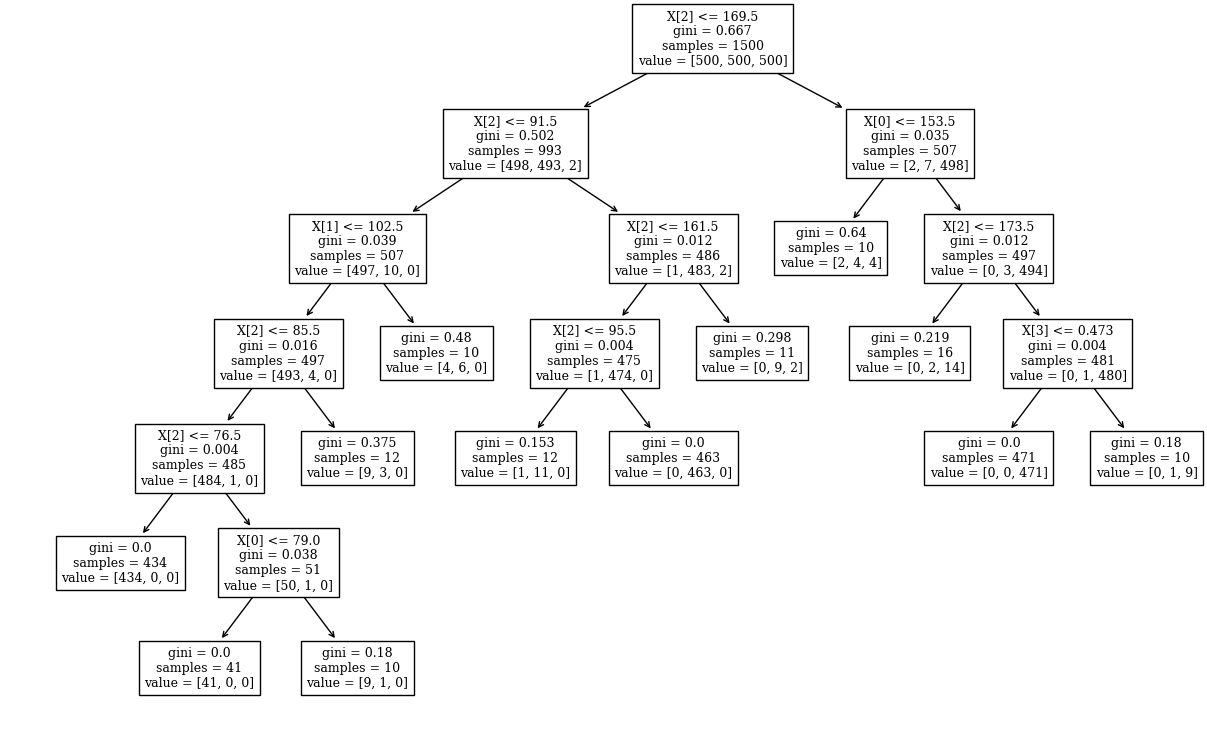

In [192]:
# plot decision tree
plt.figure(figsize=(11, 7), dpi=100)
tree.plot_tree(clf,fontsize=9)
print()
# X[3],X[4] loc,size features rarely used in the splits; can be dropped

In [90]:
# decision tree classifier: use only color features
clf = tree.DecisionTreeClassifier(min_samples_leaf=10)
# perform 5-fold CV: stratified k-fold
scores = cross_val_score(clf, tr_feat_mat[:,:3], tr_labels, cv=5, scoring='accuracy')
print('CV folds accuracies:',scores)
print("CV results: %0.4f ave accuracy with a standard deviation of %0.4f" % (scores.mean(), scores.std()))
# train final model
clf = clf.fit(tr_feat_mat[:,:3], tr_labels)
val_pred = clf.predict(val_feat_mat[:,:3])
tr_pred = clf.predict(tr_feat_mat[:,:3])
print('Train and validation accuracies:',np.round(accuracy_score(tr_labels, tr_pred),4), np.round(accuracy_score(val_labels, val_pred),4))

CV folds accuracies: [0.98       0.98333333 0.98333333 0.99333333 0.96333333]
CV results: 0.9807 ave accuracy with a standard deviation of 0.0098
Train and validation accuracies: 0.9867 0.9693


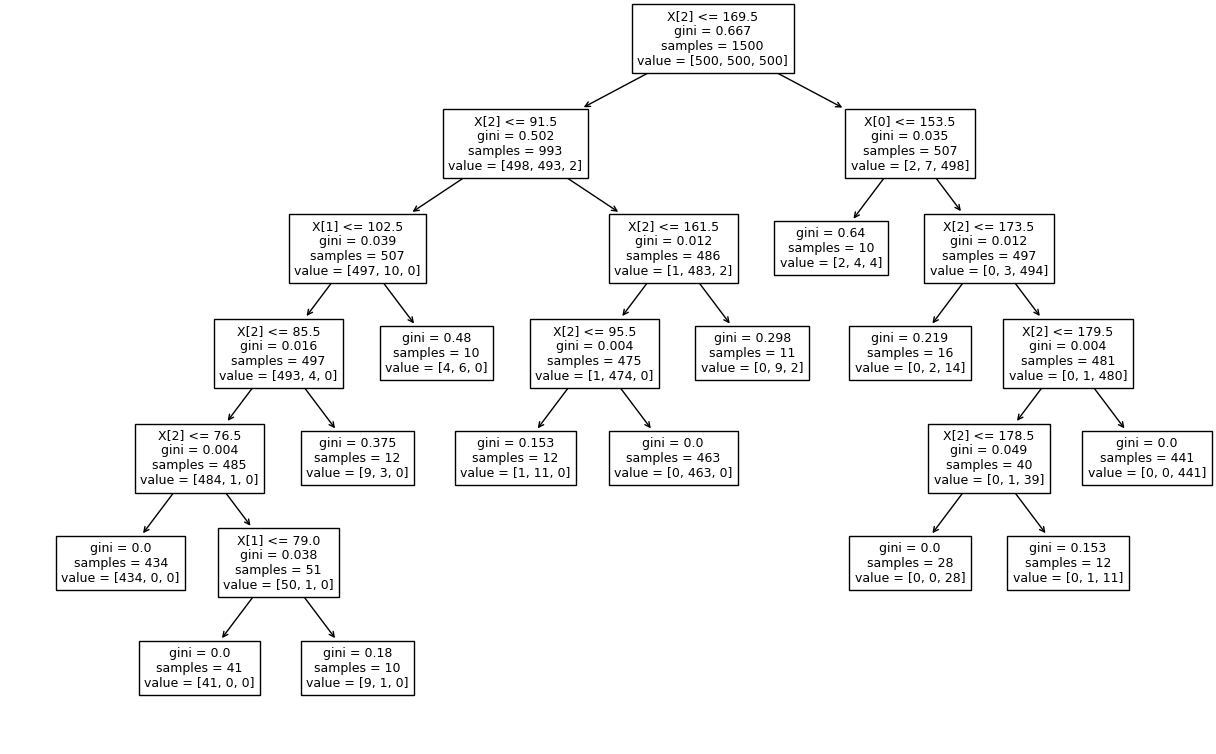

In [92]:
# plot decision tree
plt.figure(figsize=(11, 7), dpi=100)
tree.plot_tree(clf,fontsize=9)
print()

In [105]:
# logistic regression
# normalize features
scaler = StandardScaler()
tr_feat_matn = scaler.fit_transform(tr_feat_mat)
val_feat_matn = scaler.fit_transform(val_feat_mat)
clf = LogisticRegression()

# perform 5-fold CV: stratified k-fold
scores = cross_val_score(clf, tr_feat_matn, tr_labels, cv=5, scoring='accuracy')
print('CV folds accuracies:',scores)
print("CV results: %0.4f ave accuracy with a standard deviation of %0.4f" % (scores.mean(), scores.std()))
# train final model
clf = clf.fit(tr_feat_matn, tr_labels)
val_pred = clf.predict(val_feat_matn)
tr_pred = clf.predict(tr_feat_matn)
print('Train and validation accuracies:',np.round(accuracy_score(tr_labels, tr_pred),4), np.round(accuracy_score(val_labels, val_pred),4))

CV folds accuracies: [0.98333333 0.97       0.99333333 0.98       0.97666667]
CV results: 0.9807 ave accuracy with a standard deviation of 0.0077
Train and validation accuracies: 0.982 0.98


In [35]:
# random forest
clf = RandomForestClassifier(n_estimators=50, min_samples_leaf=10)
# perform 5-fold CV: stratified k-fold
scores = cross_val_score(clf, tr_feat_mat, tr_labels, cv=5, scoring='accuracy')
print('CV folds accuracies:',scores)
print("CV results: %0.4f ave accuracy with a standard deviation of %0.4f" % (scores.mean(), scores.std()))
# train final model
clf = clf.fit(tr_feat_mat, tr_labels)
val_pred = clf.predict(val_feat_mat)
val_pred_prob = clf.predict_proba(val_feat_mat)
tr_pred = clf.predict(tr_feat_mat)
print('Train and validation accuracies:',np.round(accuracy_score(tr_labels, tr_pred),4), np.round(accuracy_score(val_labels, val_pred),4))

CV folds accuracies: [0.99333333 0.98333333 0.98666667 0.99333333 0.98666667]
CV results: 0.9887 ave accuracy with a standard deviation of 0.0040
Train and validation accuracies: 0.992 0.9847


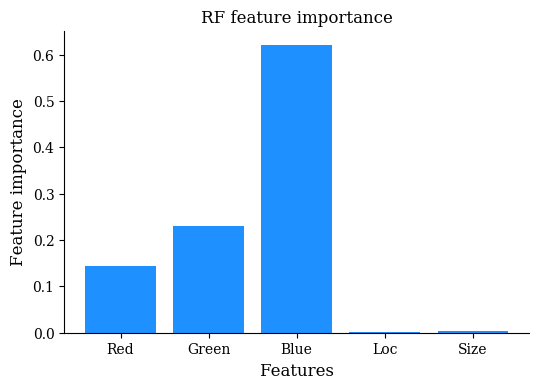

In [188]:
# feature importance: based on mean decrease in impurity
plt.figure(figsize=(6, 4), dpi=100)
plt.rc('font', family='serif')
myfontsize = 12
ax = plt.subplot()
plt.bar(height=clf.feature_importances_,x=feature_names,facecolor='dodgerblue')
plt.title('RF feature importance',fontsize=myfontsize)
plt.xlabel("Features",fontsize=myfontsize)
plt.ylabel("Feature importance",fontsize=myfontsize)
plt.tick_params(axis='both', which='major', labelsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# misclassified validation samples: 23

Sample pred prob: [0.76 0.24 0.  ]


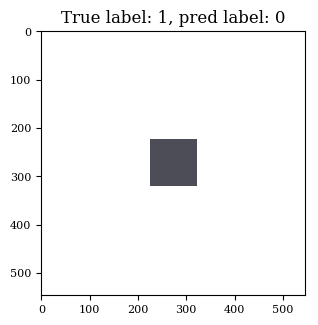

In [43]:
# misclassified validation samples by RF
miscls_inds = np.where(val_labels-val_pred!=0)[0]
print('# misclassified validation samples:',miscls_inds.shape[0])
print()
ind = 523 # an index from miscls_inds 
img_path = val_img_paths[ind]

plt.figure(figsize=(3.5, 3.5), dpi=100)
plt.rc('font', family='serif')
myfontsize = 11
img = io.imread(img_path)
ax = plt.subplot()
plt.imshow(img)
plt.title('True label: '+str(val_labels[ind])+', pred label: '+str(val_pred[ind]))
plt.tick_params(axis='both', which='major', labelsize=8)
print('Sample pred prob:',val_pred_prob[ind,:].round(2))

Sample pred prob: [0.  0.3 0.7]


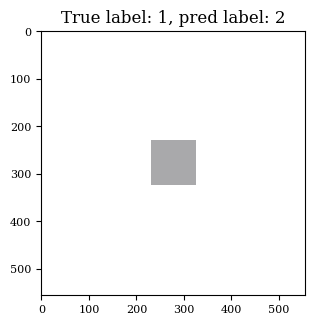

In [44]:
# misclassified validation samples by RF
ind = 500 # an index from miscls_inds 
img_path = val_img_paths[ind]

plt.figure(figsize=(3.5, 3.5), dpi=100)
plt.rc('font', family='serif')
myfontsize = 11
img = io.imread(img_path)
ax = plt.subplot()
plt.imshow(img)
plt.title('True label: '+str(val_labels[ind])+', pred label: '+str(val_pred[ind]))
plt.tick_params(axis='both', which='major', labelsize=8)
print('Sample pred prob:',val_pred_prob[ind,:].round(2))